In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *
import numpy as onp

: 

## Optimize an encoder based on entropy as a loss function

In [2]:
N_objects = 2000
noise_sigma = 0.01
N_objects_to_plot = 1
N_signals_to_plot = 6
# erasure_mask = onp.ones(NUM_NYQUIST_SAMPLES)

erasure_mask = onp.ones(NUM_NYQUIST_SAMPLES)
# non_erased_indices = onp.random.choice(erasure_mask.size, int(erasure_mask.size * 0.25), replace=False)

erasure_mask = np.array(erasure_mask, dtype=bool)

objects_fn = lambda : np.array([sample_amplitude_object('delta', num_deltas=1) for i in range(N_objects)])
# objects_fn = lambda : np.array([sample_amplitude_object('delta', num_deltas=5) for i in range(N_objects)])
# objects_fn = lambda : np.array([sample_amplitude_object('pink_noise') for i in range(N_objects)])
# objects_fn = lambda : np.array([sample_amplitude_object('white_noise') for i in range(N_objects)])
# objects_fn = lambda : np.array([sample_amplitude_object('random_amplitude_delta') for i in range(N_objects)])
# objects_fn = lambda : np.array([sample_amplitude_object('random_pairs') for i in range(N_objects)])
# objects_fn = lambda : np.array([sample_amplitude_object('delta_in_some_places') for i in range(N_objects)])
# objects_fn = lambda : np.array([sample_amplitude_object('sinusoid', sin_freq_range=(9, 10)) for i in range(N_objects)])

initial_kernel, initial_params, optimized_params, objects, initial_mi, optimized_mi = optimize_PSF_and_estimate_mi(objects_fn, noise_sigma, erasure_mask)


initial loss -0.8343992060130262


Text(0.5, 0.98, 'Optimized MI: 2.74 bits')

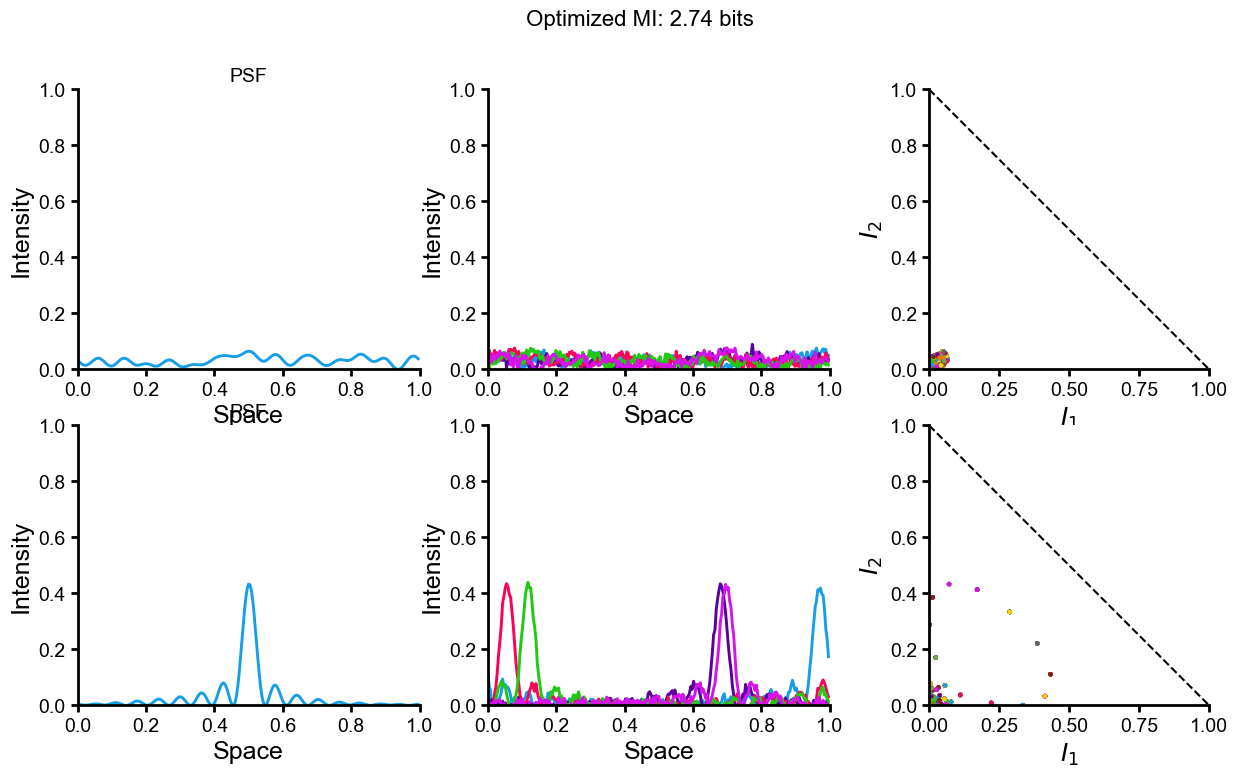

In [34]:
sampling_indices = (1, 2)

fig, ax = plt.subplots(2, 3, figsize=(15, 8))

make_PSF_output_signal_plot(ax[0], initial_params, objects, erasure_mask, noise_sigma, initial_mi, sampling_indices=sampling_indices)
make_PSF_output_signal_plot(ax[1], optimized_params, objects, erasure_mask, noise_sigma, optimized_mi, sampling_indices=sampling_indices)
fig.suptitle(f'Optimized MI: {optimized_mi:.2f} bits', fontsize=16)


## Erasure and the optimal PSF
Run a bunch of optimizations with different initializations and find the best PSFs with and without erasure of the measurement pixels

In [3]:

N_objects = 2000
num_loops = 10
noise_sigma = 1e-3

nonuniform_object_positions = True

objects_fn = lambda : np.array([sample_amplitude_object('delta', num_deltas=1, num_mixture_components=2,
                                             gaussian_mixture_position=nonuniform_object_positions) for i in range(N_objects)])

objects = objects_fn()
test_objects = objects_fn()

### erase sensor pixels
# optimize with same init
erasure_mask = onp.zeros(NUM_NYQUIST_SAMPLES)
# erasure_mask[int(0.1 * erasure_mask.size): int(0.2 * erasure_mask.size)] = 1
# erasure_mask[int(0.3 * erasure_mask.size): int(0.4 * erasure_mask.size)] = 1
# erasure_mask[int(0.45 * erasure_mask.size): int(0.55 * erasure_mask.size)] = 1
# erasure_mask[int(0.7 * erasure_mask.size): int(0.8 * erasure_mask.size)] = 1
# erasure_mask[int(0.9 * erasure_mask.size): int(erasure_mask.size)] = 1
# erasure_mask = np.array(erasure_mask, dtype=bool)

# make an erasur mask with 90% of the pixels erased
onp.random.seed(123)
erasure_mask = onp.zeros(NUM_NYQUIST_SAMPLES)
non_erased_indices = onp.random.choice(erasure_mask.size, int(erasure_mask.size * 0.25), replace=False)
erasure_mask[non_erased_indices] = 1
erasure_mask = np.array(erasure_mask, dtype=bool)

non_erasure_mask = np.ones(erasure_mask.size, dtype=bool)


best_erasure_mi = -np.inf
best_no_erasure_mi = -np.inf

for _ in tqdm(range(num_loops)):
  initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=np.ones(NUM_NYQUIST_SAMPLES) + onp.random.rand(NUM_NYQUIST_SAMPLES) * 0.5)

  initial_kernel, initial_params, optimized_params_no_erasure, objects, initial_mi, optimized_mi_no_erasure = optimize_PSF_and_estimate_mi(
    objects_fn, noise_sigma, non_erasure_mask, initial_kernel=initial_kernel)

  initial_kernel, initial_params, optimized_params_with_erasure, objects, initial_mi, optimized_mi_with_erasure = optimize_PSF_and_estimate_mi(
    objects_fn, noise_sigma, erasure_mask, initial_kernel=initial_kernel)

  print(f'Optimized mi without erasure: {optimized_mi_no_erasure:.4f}')
  print(f'Optimized mi with erasure: {optimized_mi_with_erasure:.4f}')

  if optimized_mi_no_erasure > best_no_erasure_mi:
    best_no_erasure_mi = optimized_mi_no_erasure
    best_no_erasure_params = optimized_params_no_erasure
  if optimized_mi_with_erasure > best_erasure_mi:
    best_erasure_mi = optimized_mi_with_erasure
    best_erasure_params = optimized_params_with_erasure



  0%|          | 0/10 [00:00<?, ?it/s]

initial loss -0.707682480849869
initial loss -1.322146391574071


 10%|█         | 1/10 [01:52<16:50, 112.26s/it]

Optimized mi without erasure: 2.9115
Optimized mi with erasure: 4.7675
initial loss -0.782965726893835
initial loss -1.4995205092050226


 20%|██        | 2/10 [04:13<17:15, 129.40s/it]

Optimized mi without erasure: 2.8879
Optimized mi with erasure: 5.3989
initial loss -0.8179826082482488
initial loss -1.593346452950116


 30%|███       | 3/10 [06:29<15:25, 132.27s/it]

Optimized mi without erasure: 2.9880
Optimized mi with erasure: 4.9892
initial loss -0.817330069419285
initial loss -1.4578842638788831


 40%|████      | 4/10 [08:43<13:16, 132.83s/it]

Optimized mi without erasure: 2.9729
Optimized mi with erasure: 5.4216
initial loss -0.7442409229968519
initial loss -1.2752185644300287


 50%|█████     | 5/10 [10:59<11:11, 134.26s/it]

Optimized mi without erasure: 2.9165
Optimized mi with erasure: 4.6799
initial loss -0.8265144220489026
initial loss -1.547767539978576


 60%|██████    | 6/10 [13:18<09:03, 135.80s/it]

Optimized mi without erasure: 2.5935
Optimized mi with erasure: 5.2506
initial loss -0.8138819569125599
initial loss -1.6416677197510685


 70%|███████   | 7/10 [15:35<06:48, 136.08s/it]

Optimized mi without erasure: 2.7511
Optimized mi with erasure: 5.4364
initial loss -0.9132545916174772
initial loss -1.7422578591155822


 80%|████████  | 8/10 [17:51<04:32, 136.23s/it]

Optimized mi without erasure: 2.5142
Optimized mi with erasure: 5.2659
initial loss -0.8934345342766944
initial loss -1.593840340280226


 90%|█████████ | 9/10 [20:07<02:16, 136.20s/it]

Optimized mi without erasure: 2.9876
Optimized mi with erasure: 5.3314
initial loss -0.8011244649529712
initial loss -1.2976083384466672


100%|██████████| 10/10 [22:25<00:00, 134.56s/it]

Optimized mi without erasure: 2.7152
Optimized mi with erasure: 5.3955


Text(0.5, 0.98, 'Initial MI: 1.30 Optimized MI without erasure: 2.72 Optimized MI with erasure: 5.40 bits')

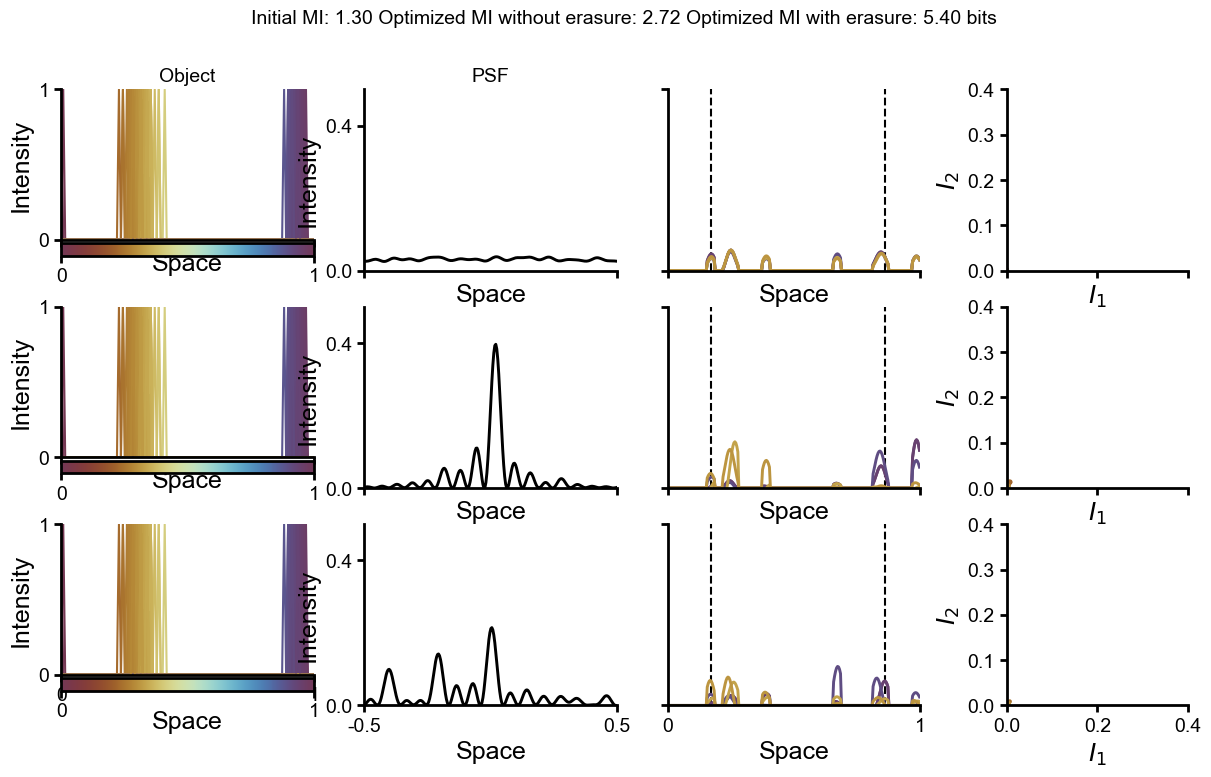

In [4]:
from plot_utils_1D import *

N_signals_to_plot = 40
example_objects = test_objects[:N_signals_to_plot]


########################## Plot the results #####################################
intensity_lim_max = 0.4
# sampling indices are two random non-erased indices
sampling_indices = onp.random.choice(non_erased_indices, 2, replace=False)
# make the smaller one first
sampling_indices = np.sort(sampling_indices)

fig, ax = plt.subplots(3, 4, figsize=(15, 8), sharex='col')
make_delta_fn_object_PSF_plot(ax[0], initial_params, objects, erasure_mask, noise_sigma, psf_y_max=0.5,
                              intensity_lim_max=intensity_lim_max, sampling_indices=sampling_indices, titles=True)
make_delta_fn_object_PSF_plot(ax[1], best_no_erasure_params, objects, erasure_mask, noise_sigma, psf_y_max=0.5,
                              intensity_lim_max=intensity_lim_max, sampling_indices=sampling_indices)
make_delta_fn_object_PSF_plot(ax[2], best_erasure_params, objects, erasure_mask, noise_sigma, psf_y_max=0.5,
                              intensity_lim_max=intensity_lim_max, sampling_indices=sampling_indices)

fig.suptitle(f'Initial MI: {initial_mi:.2f} '
                f'Optimized MI without erasure: {optimized_mi_no_erasure:.2f} '
                f'Optimized MI with erasure: {optimized_mi_with_erasure:.2f} bits', fontsize=14)

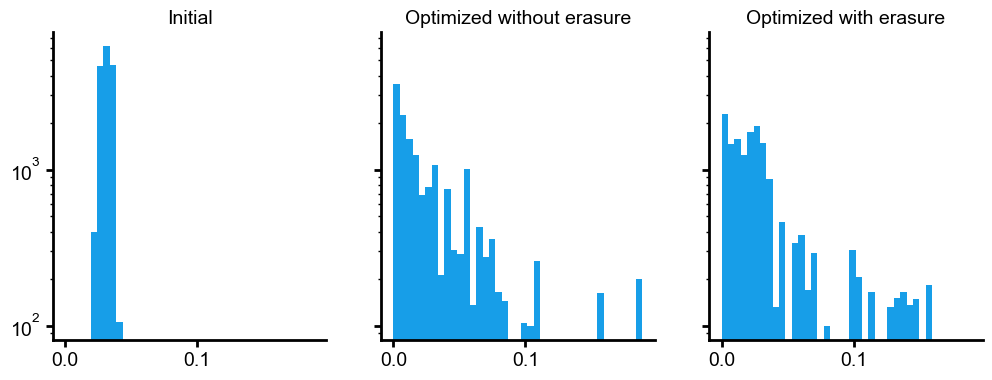

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

signals_list = [conv_forward_model_with_erasure(params, objects, erasure_mask, align_center=False) 
                for params in [initial_params, optimized_params_no_erasure, optimized_params_with_erasure]]

bins = np.linspace(0, np.array(signals_list).max(), 40)
for name, i, signals in zip(['Initial', 'Optimized without erasure', 'Optimized with erasure'], range(3), signals_list):
    ax[i].hist(signals[:, erasure_mask].ravel(), bins=bins, log=True)
    ax[i].set_title(name)
    clear_spines(ax[i])


### Initialize with best non-erasure params and see that it changes

In [49]:
decay = 0.999

initial_kernel = conv_kernel_from_params(optimized_params_no_erasure)
initial_kernel, initial_params, optimized_params, objects, initial_mi, optimized_mi_no_erasure = optimize_PSF_and_estimate_mi(
                objects_fn, noise_sigma, erasure_mask, initial_kernel=initial_kernel, learning_rate=1e-4)

initial loss -5.7306017013166475


KeyboardInterrupt: 

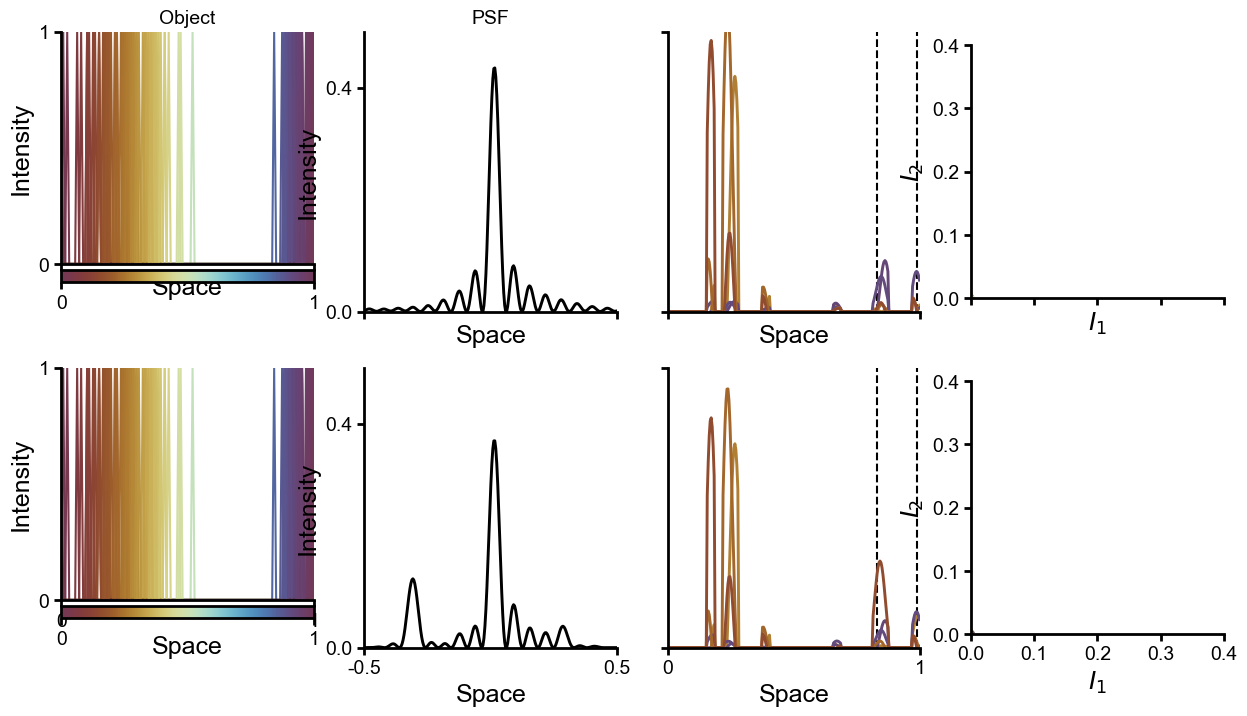

In [48]:
########################## Plot the results #####################################
intensity_lim_max = 0.4
# sampling indices are two random non-erased indices
sampling_indices = onp.random.choice(non_erased_indices, 2, replace=False)
# make the smaller one first
sampling_indices = np.sort(sampling_indices)

fig, ax = plt.subplots(2, 4, figsize=(15, 8), sharex='col')
make_delta_fn_object_PSF_plot(ax[0], initial_params, objects, erasure_mask, noise_sigma, psf_y_max=0.5,
                              intensity_lim_max=intensity_lim_max, sampling_indices=sampling_indices, titles=True)
make_delta_fn_object_PSF_plot(ax[1], optimized_params, objects, erasure_mask, noise_sigma, psf_y_max=0.5,
                              intensity_lim_max=intensity_lim_max, sampling_indices=sampling_indices)


# Compare to uniformly located delta functions

In [50]:
N_objects = 2000
num_loops = 1
noise_sigma = 1e-3

nonuniform_object_positions = False

objects_fn = lambda : np.array([sample_amplitude_object('delta', num_deltas=1,
                                             gaussian_mixture_position=nonuniform_object_positions) for i in range(N_objects)])

objects = objects_fn()
test_objects = objects_fn()

### erase sensor pixels
# optimize with same init
erasure_mask = onp.zeros(NUM_NYQUIST_SAMPLES)
# erasure_mask[int(0.1 * erasure_mask.size): int(0.2 * erasure_mask.size)] = 1
# erasure_mask[int(0.3 * erasure_mask.size): int(0.4 * erasure_mask.size)] = 1
# erasure_mask[int(0.45 * erasure_mask.size): int(0.55 * erasure_mask.size)] = 1
# erasure_mask[int(0.7 * erasure_mask.size): int(0.8 * erasure_mask.size)] = 1
# erasure_mask[int(0.9 * erasure_mask.size): int(erasure_mask.size)] = 1
# erasure_mask = np.array(erasure_mask, dtype=bool)

# make an erasur mask with 90% of the pixels erased
onp.random.seed(123)
erasure_mask = onp.zeros(NUM_NYQUIST_SAMPLES)
non_erased_indices = onp.random.choice(erasure_mask.size, int(erasure_mask.size * 0.25), replace=False)
erasure_mask[non_erased_indices] = 1
erasure_mask = np.array(erasure_mask, dtype=bool)

non_erasure_mask = np.ones(erasure_mask.size, dtype=bool)


best_erasure_mi = -np.inf
best_no_erasure_mi = -np.inf

for _ in tqdm(range(num_loops)):
  initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=np.ones(NUM_NYQUIST_SAMPLES) + onp.random.rand(NUM_NYQUIST_SAMPLES) * 0.5)

  initial_kernel, initial_params, optimized_params_no_erasure, objects, initial_mi, optimized_mi_no_erasure = optimize_PSF_and_estimate_mi(
    objects_fn, noise_sigma, non_erasure_mask, initial_kernel=initial_kernel)

  initial_kernel, initial_params, optimized_params_with_erasure, objects, initial_mi, optimized_mi_with_erasure = optimize_PSF_and_estimate_mi(
    objects_fn, noise_sigma, erasure_mask, initial_kernel=initial_kernel)

  print(f'Optimized mi without erasure: {optimized_mi_no_erasure:.4f}')
  print(f'Optimized mi with erasure: {optimized_mi_with_erasure:.4f}')

  if optimized_mi_no_erasure > best_no_erasure_mi:
    best_no_erasure_mi = optimized_mi_no_erasure
    best_no_erasure_params = optimized_params_no_erasure
  if optimized_mi_with_erasure > best_erasure_mi:
    best_erasure_mi = optimized_mi_with_erasure
    best_erasure_params = optimized_params_with_erasure



  0%|          | 0/1 [00:00<?, ?it/s]

initial loss -1.320166234006168


initial loss -1.6473997917243597


100%|██████████| 1/1 [01:29<00:00, 89.33s/it]

Optimized mi without erasure: 5.9471
Optimized mi with erasure: 6.4867


Text(0.5, 0.98, 'Initial MI: 1.65 Optimized MI without erasure: 5.95 Optimized MI with erasure: 6.49 bits')

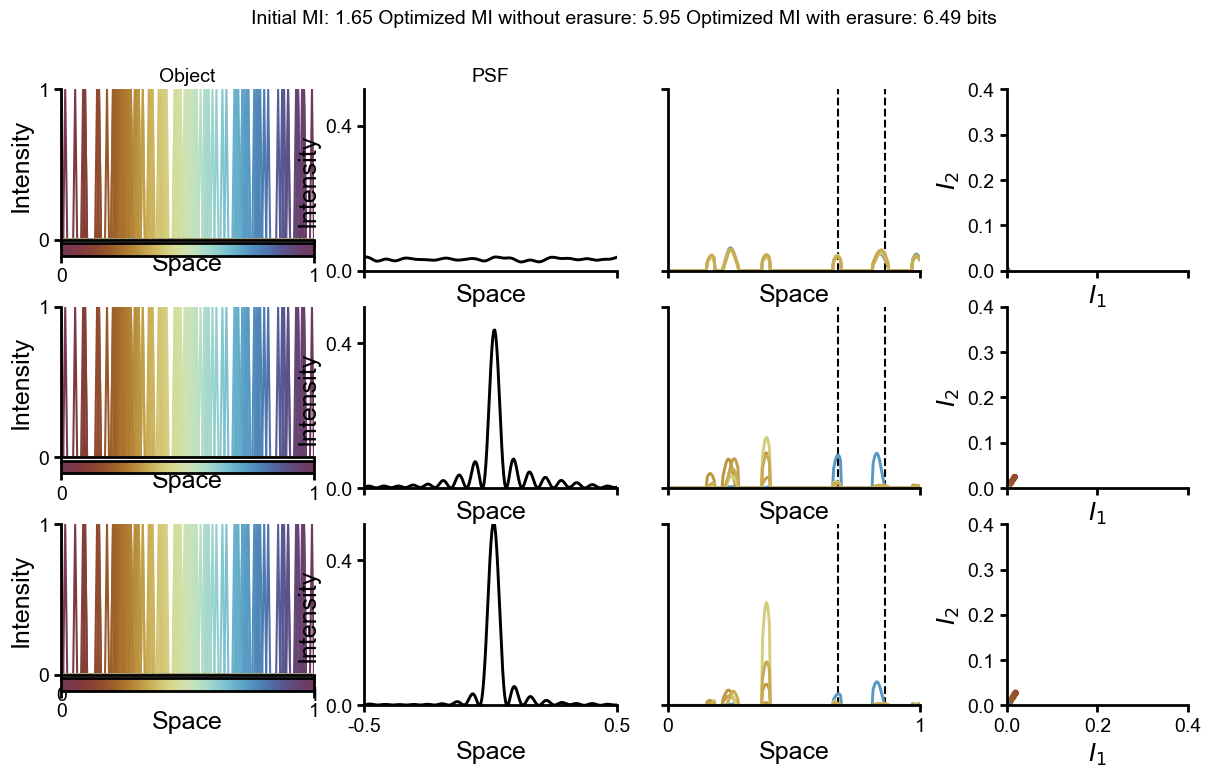

In [51]:
N_signals_to_plot = 40
example_objects = test_objects[:N_signals_to_plot]


########################## Plot the results #####################################
intensity_lim_max = 0.4
# sampling indices are two random non-erased indices
sampling_indices = onp.random.choice(non_erased_indices, 2, replace=False)
# make the smaller one first
sampling_indices = np.sort(sampling_indices)

fig, ax = plt.subplots(3, 4, figsize=(15, 8), sharex='col')
make_delta_fn_object_PSF_plot(ax[0], initial_params, objects, erasure_mask, noise_sigma, psf_y_max=0.5,
                              intensity_lim_max=intensity_lim_max, sampling_indices=sampling_indices, titles=True)
make_delta_fn_object_PSF_plot(ax[1], best_no_erasure_params, objects, erasure_mask, noise_sigma, psf_y_max=0.5,
                              intensity_lim_max=intensity_lim_max, sampling_indices=sampling_indices)
make_delta_fn_object_PSF_plot(ax[2], best_erasure_params, objects, erasure_mask, noise_sigma, psf_y_max=0.5,
                              intensity_lim_max=intensity_lim_max, sampling_indices=sampling_indices)

fig.suptitle(f'Initial MI: {initial_mi:.2f} '
                f'Optimized MI without erasure: {optimized_mi_no_erasure:.2f} '
                f'Optimized MI with erasure: {optimized_mi_with_erasure:.2f} bits', fontsize=14)

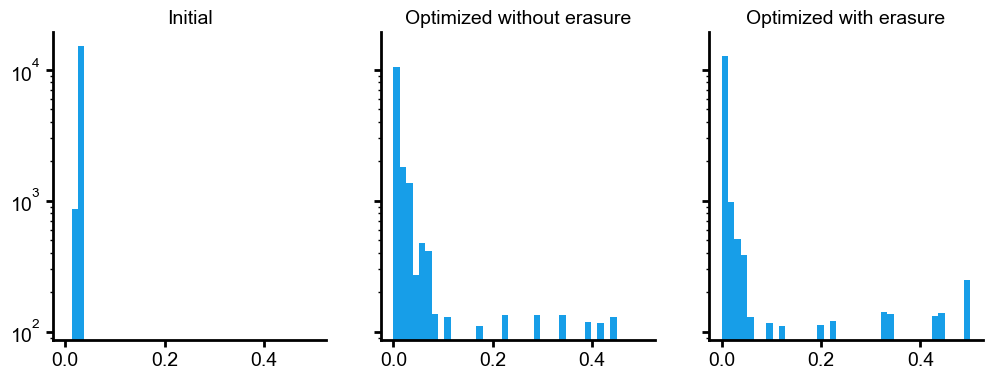

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

signals_list = [conv_forward_model_with_erasure(params, objects, erasure_mask, align_center=False) 
                for params in [initial_params, optimized_params_no_erasure, optimized_params_with_erasure]]

bins = np.linspace(0, np.array(signals_list).max(), 40)
for name, i, signals in zip(['Initial', 'Optimized without erasure', 'Optimized with erasure'], range(3), signals_list):
    ax[i].hist(signals[:, erasure_mask].ravel(), bins=bins, log=True)
    ax[i].set_title(name)
    clear_spines(ax[i])
